# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import lya_theory
import likelihood
import emcee_sampler

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_15052019/'
p1d_label='p1d'
skewers_label='Ns110_wM0.1'
use_gp=False
if use_gp:
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=1000,verbose=True,paramList=None,kmax_Mpc=5,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,drop_tau_rescalings=False,drop_temp_rescalings=False,verbose=True)

latin hyper-cube data {'param_space': {'Om_star': {'ip': 0, 'min_val': 0.955, 'max_val': 0.975, 'z_star': 3.0, 'latex': '$\\Omega_\\star$'}, 'Delta2_star': {'ip': 1, 'min_val': 0.25, 'max_val': 0.45, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\Delta^2_\\star$'}, 'n_star': {'ip': 2, 'min_val': -2.35, 'max_val': -2.25, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$n_\\star$'}, 'alpha_star': {'ip': 3, 'min_val': -0.265, 'max_val': -0.165, 'z_star': 3.0, 'kp_Mpc': 0.7, 'latex': '$\\alpha_\\star$'}, 'mu_He': {'ip': 4, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$\\mu_{\\rm He}$'}, 'mu_H': {'ip': 5, 'min_val': 0.5, 'max_val': 2.0, '   latex': '$\\mu_{\\rm H}$'}}, 'nsamples': 10, 'samples': {'0': [0.96, 0.32, -2.325, -0.22, 0.875, 1.7750000000000001], '1': [0.966, 0.4, -2.295, -0.23, 1.175, 0.575], '2': [0.968, 0.36, -2.285, -0.26, 1.7750000000000001, 1.625], '3': [0.97, 0.3, -2.315, -0.18, 1.3250000000000002, 1.3250000000000002], '4': [0.974, 0.34, -2.305, -0.21000000000000002, 1.475, 1.175], '5': [

In [4]:
# specify free parameters in likelihood
free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_T0_1','ln_gamma_0','ln_gamma_1']

In [5]:
sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,verbose=False)

Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model
got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
updated 0 linP parameters
updated 2 after mean flux parameters
updated 2 after thermal parameters
0 2.2 model {'Delta2_p': 0.55651130145771688, 'n_p': -2.2994794185069685, 'alpha_p': -0.21637589659957746, 'f_p': 0.96522452450210083, 'mF': 0.82289980637146687, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.13069600926052841}
1 2.4 model {'Delta2_p': 0.49488568402750766, 'n_p': -2.2994795015019927, 'alpha_p': -0.21637671767578953, 'f_p': 0.97065366319224333, 'mF': 0.78133787897751317, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12744692725288601}
2 2.6 model {'Delta2_p': 0.44280074273630693, 'n_p': -2.2994793009304835,

In [6]:
for p in sampler.like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.712743835225
ln_tau_1 4.43656459216


### Run burn-in chains

In [7]:
sampler.go_silent()

In [8]:
sampler.run_burn_in(nsteps=50)

### Run main chains

In [9]:
sampler.run_chains(nsteps=100)

0 [ 0.66408835  0.67897786]
20 [ 0.65138438  0.67486754]
40 [ 0.64875239  0.69315394]
60 [ 0.65375192  0.66881075]
80 [ 0.6669619   0.69565396]


In [10]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.686


### Plot results in cube units (0 < x < 1)

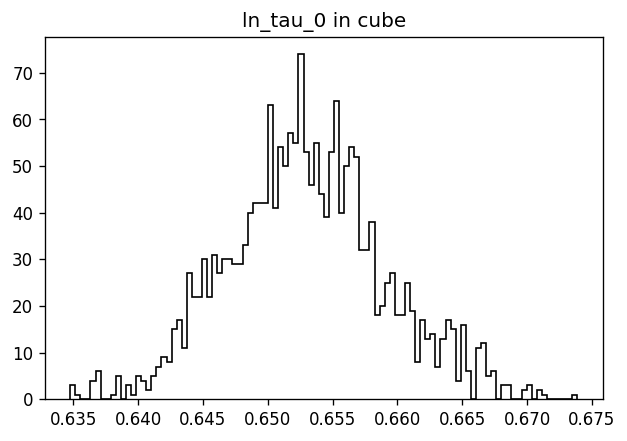

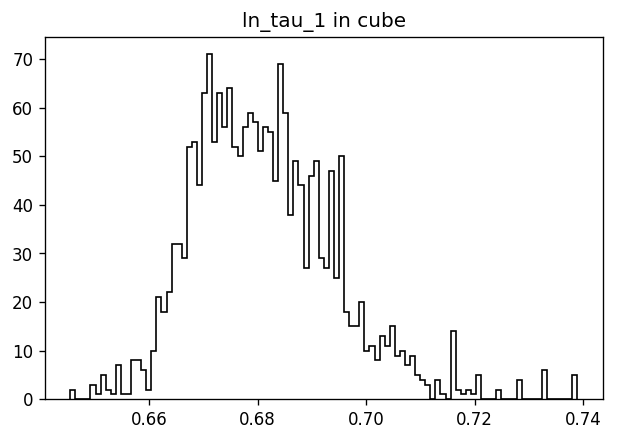

In [11]:
sampler.plot_histograms(cube=True)

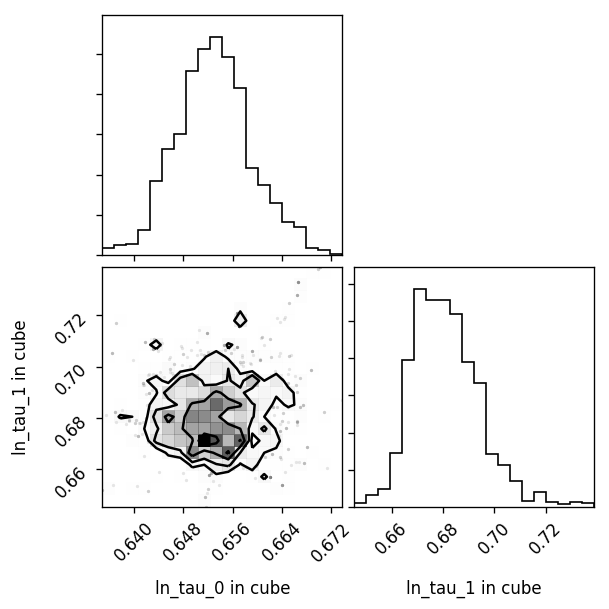

In [12]:
sampler.plot_corner(cube=True)

### Plot results for dimensional parameters

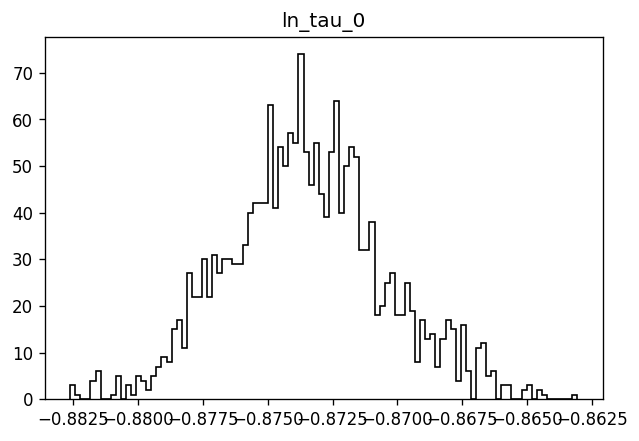

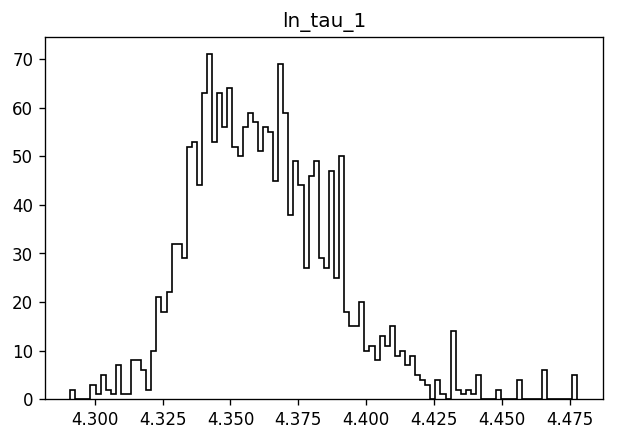

In [13]:
sampler.plot_histograms(cube=False)

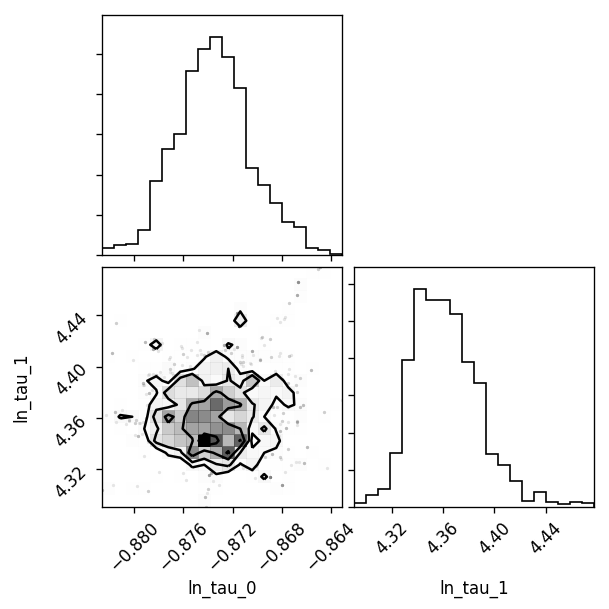

In [14]:
sampler.plot_corner(cube=False)

### Use likelihood object to make other useful plots

In [15]:
# get mean of chain
mcmc_mean=np.mean(sampler.sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.65301628  0.68140534]


In [16]:
sampler.like.update_parameters(mcmc_mean)
for p in sampler.like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.873491857917
ln_tau_1 4.36281068306


Text(0, 0.5, '<F>')

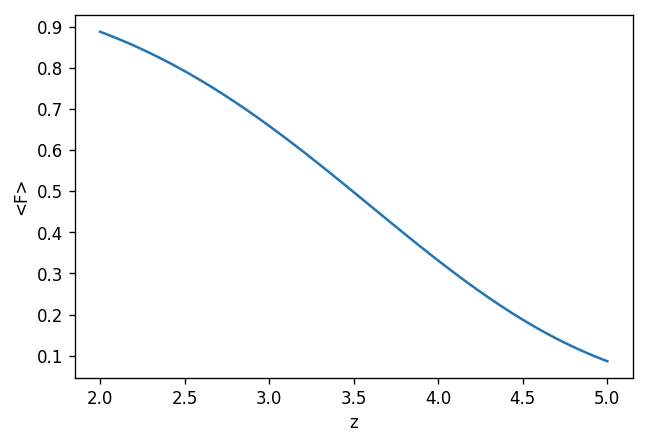

In [17]:
z=np.linspace(2.0,5.0,100)
mf=sampler.like.theory.mf_model.get_mean_flux(z)
plt.plot(z,mf)
plt.xlabel('z')
plt.ylabel('<F>')

Text(0, 0.5, '$T_0(z)$ [K]')

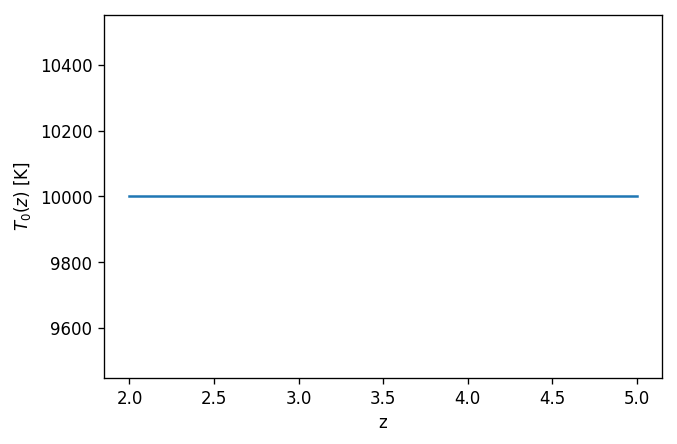

In [18]:
T0=sampler.like.theory.T_model.get_T0(z)
plt.plot(z,T0)
plt.xlabel('z')
plt.ylabel(r'$T_0(z)$ [K]')

Text(0, 0.5, '$\\sigma_T(z)$ [km/s]')

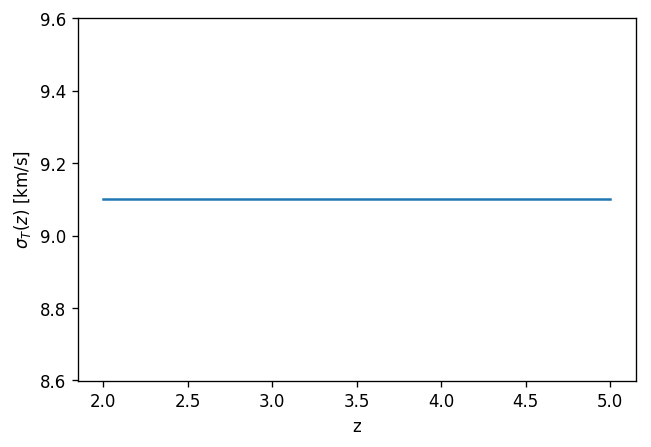

In [19]:
sigT=sampler.like.theory.T_model.get_sigT_kms(T0)
plt.plot(z,sigT)
plt.xlabel('z')
plt.ylabel(r'$\sigma_T(z)$ [km/s]')

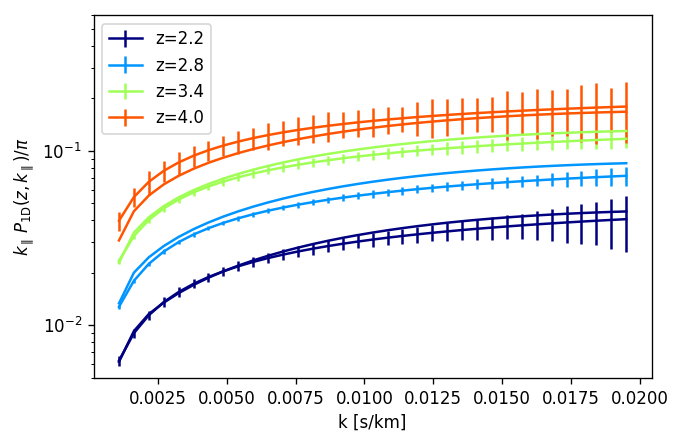

In [20]:
sampler.like.plot_p1d()

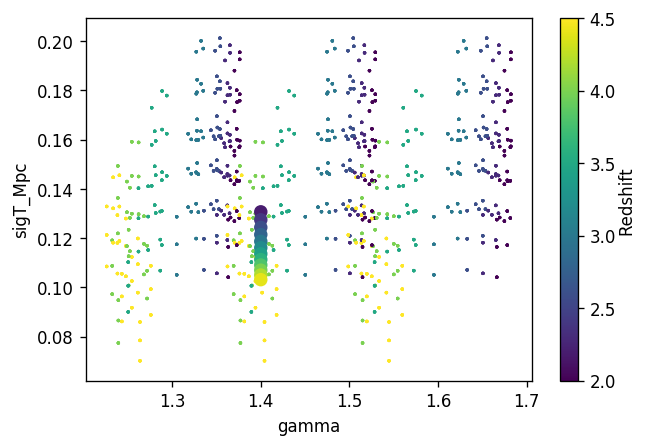

In [21]:
sampler.like.overplot_emulator_calls('gamma','sigT_Mpc')

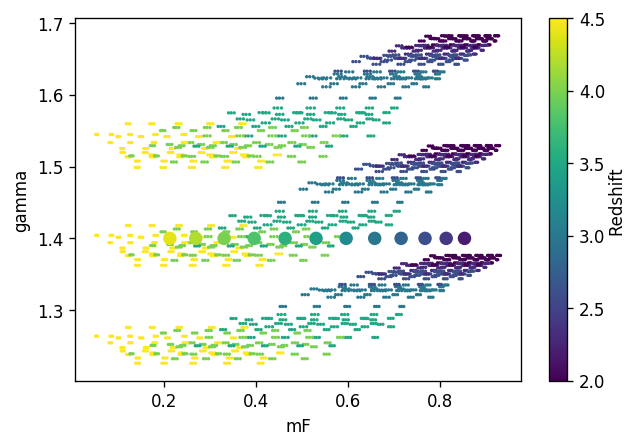

In [22]:
sampler.like.overplot_emulator_calls('mF','gamma')

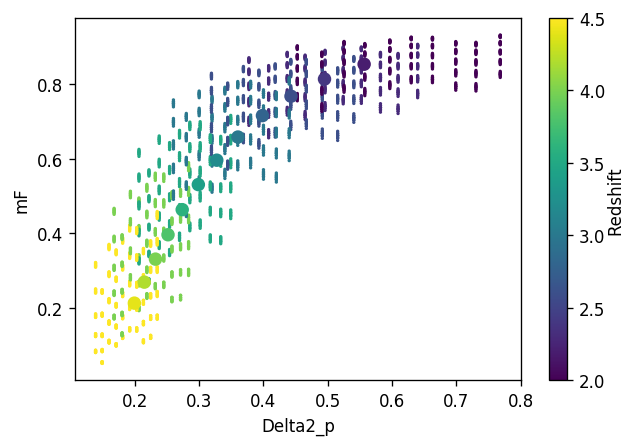

In [23]:
sampler.like.overplot_emulator_calls('Delta2_p','mF')

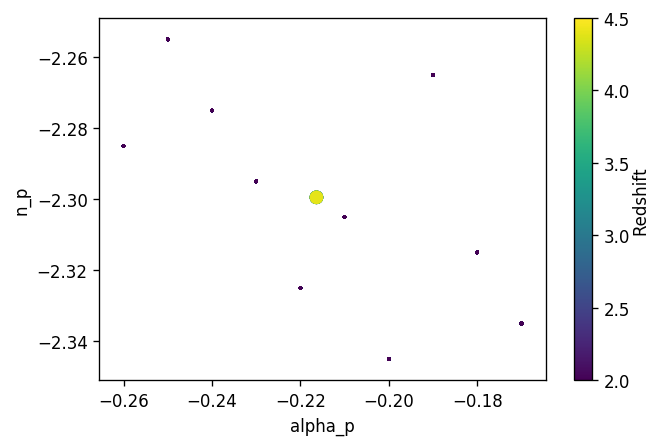

In [24]:
sampler.like.overplot_emulator_calls('alpha_p','n_p')

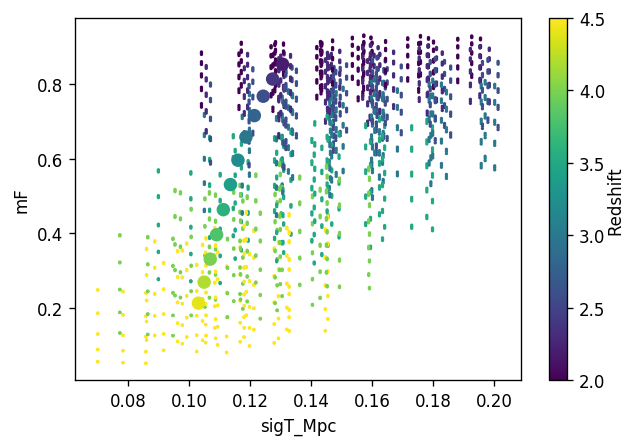

In [25]:
sampler.like.overplot_emulator_calls('sigT_Mpc','mF')

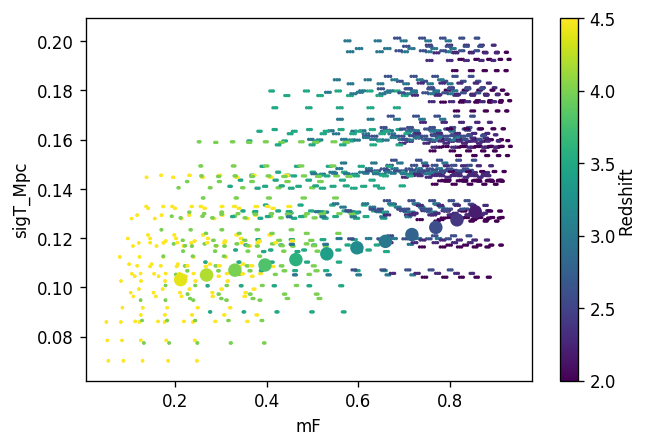

In [26]:
sampler.like.overplot_emulator_calls('mF','sigT_Mpc')